# Day 4: Black-Litterman Model
## Week 5: Portfolio Optimization

---

### 🎯 Learning Objectives
- Understand market equilibrium returns
- Incorporate views into optimization
- Implement the Black-Litterman model
- Compare to traditional MVO

| Intuition | Low | High |

---| Portfolios | Extreme | Diversified |

| Return estimates | Required | Optional (views) |

### 📈 Why Black-Litterman is the Industry Standard| Starting point | Zero | Market portfolio |

|--------|-----|----------------|

**Black-Litterman solved MVO's biggest problems:**| Aspect | MVO | Black-Litterman |

1. No need to estimate expected returns (use market-implied)

2. Intuitive way to incorporate views### BL vs Traditional MVO

3. Stable, diversified portfolios

| **Risk Budgeting** | Allocate active risk to best ideas |

### The Brilliant Insight| **Active Management** | Quantify confidence in views |

| **Asset Allocation** | Tilt from market cap weights based on views |

**The market portfolio IS the optimal portfolio (in equilibrium).**|-------------|-------------|

| Application | How BL Helps |

So start there, then adjust for your views.

### Trading Applications

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Constants
TRADING_DAYS = 252  # Trading days per year
RF_RATE = 0.05  # Risk-free rate (5%)

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1254 days


## 1. The Black-Litterman Intuition

### 🎯 Starting from Market Wisdom

**Problem with MVO**: Requires expected return estimates that are notoriously unreliable.

**Black-Litterman Solution**:
1. Start with market equilibrium returns (implied by market cap weights)

2. Blend in your views with confidence levelsIf the market is in equilibrium, investors must expect returns that justify holding the market portfolio. BL reverse-engineers these returns.

3. Get more stable, intuitive portfolios

### Why This Works

### The Key Equation

| $w_{mkt}$ | Market cap weights |

**Equilibrium returns:** $\pi = \delta \Sigma w_{mkt}$| $\Sigma$ | Covariance matrix |

| $\delta$ | Risk aversion (typically 2-4) |

| Variable | Meaning || $\pi$ | Implied expected returns |
|----------|--------|

In [2]:
# Market cap weights (simplified)
print("=" * 60)
print("MARKET EQUILIBRIUM RETURNS")
print("=" * 60)

# Approximate market caps ($B) - matching our tickers
market_caps = {
    'AAPL': 3000,
    'MSFT': 2800,
    'GOOGL': 1800,
    'JPM': 500,
    'GS': 150
}

# Market cap weights
total_cap = sum(market_caps.values())
market_weights = np.array([market_caps[a] / total_cap for a in tickers])

print("\n📊 Market Cap Weights:")
for asset, weight in zip(tickers, market_weights):
    print(f"  {asset}: {weight:.2%}")

# Covariance matrix
cov_matrix = returns.cov() * TRADING_DAYS

# Risk aversion parameter (typically 2-4)
risk_aversion = 2.5

# Implied equilibrium returns: π = δΣw_mkt
equilibrium_returns = risk_aversion * cov_matrix.dot(market_weights)

print("\n📊 Implied Equilibrium Returns (Annualized):")
for asset, ret in zip(tickers, equilibrium_returns):
    print(f"  {asset}: {ret:.2%}")

# Compare to historical returns
historical_returns = returns.mean() * TRADING_DAYS

comparison = pd.DataFrame({
    'Asset': tickers,
    'Historical': historical_returns.values,
    'Equilibrium': equilibrium_returns
})
print("\n📊 Comparison:")
print(comparison.round(4).to_string(index=False))

MARKET EQUILIBRIUM RETURNS

📊 Market Cap Weights:
  AAPL: 36.36%
  MSFT: 33.94%
  GOOGL: 21.82%
  JPM: 6.06%
  GS: 1.82%

📊 Implied Equilibrium Returns (Annualized):
  AAPL: 13.43%
  MSFT: 15.05%
  GOOGL: 10.50%
  JPM: 8.02%
  GS: 10.41%

📊 Comparison:
Asset  Historical  Equilibrium
 AAPL      0.1541       0.1343
 MSFT      0.2998       0.1505
GOOGL      0.3053       0.1050
  JPM      0.2214       0.0802
   GS      0.1739       0.1041


## 2. Expressing Views

| "Bonds are safer than stocks" | Use low confidence |

### 🎯 How to Translate Investment Opinions| "Tech sector will return 12%" | P = [0.5, 0.5, 0, 0], Q = 0.12 |

| "AAPL will outperform MSFT by 3%" | P = [1, -1], Q = 0.03 |

**Two types of views:**|------|---------------|

| View | How to Express |

| View Type | Example | P matrix |

|-----------|---------|----------|### Practical Examples

| **Absolute** | "Apple will return 15%" | [1, 0, 0, ...] |

| **Relative** | "Tech will beat Banks by 5%" | [0.5, 0.5, -0.5, -0.5, ...] || Zero | Stay at market weights |

| Low (high Ω) | Small tilt |

### View Confidence| Medium | Moderate tilt |

| High (low Ω) | Large tilt from benchmark |

BL lets you express HOW confident you are:|------------|--------------------|

| Confidence | Effect on Portfolio |

In [3]:
# Express views
print("=" * 60)
print("EXPRESSING VIEWS")
print("=" * 60)

# Views are expressed as:
# P @ returns = Q + epsilon, where epsilon ~ N(0, Omega)

# View 1: AAPL will outperform MSFT by 3%
# View 2: JPM will return 10%
# View 3: GOOGL will outperform GS by 2%

n_assets = len(tickers)
n_views = 3

# P matrix: each row represents a view
# Columns correspond to tickers in order
P = np.zeros((n_views, n_assets))

# View 1: AAPL - MSFT = 3%
P[0, tickers.index('AAPL')] = 1
P[0, tickers.index('MSFT')] = -1

# View 2: JPM = 10%
P[1, tickers.index('JPM')] = 1

# View 3: GOOGL - GS = 2%
P[2, tickers.index('GOOGL')] = 1
P[2, tickers.index('GS')] = -1

# Q vector: view magnitudes
Q = np.array([0.03, 0.10, 0.02])

# View confidence (uncertainty)
view_confidence = np.array([0.5, 0.3, 0.7])  # 0 = no confidence, 1 = full confidence

print("\n📊 Views:")
print("  View 1: AAPL outperforms MSFT by 3% (confidence: 50%)")
print("  View 2: JPM returns 10% (confidence: 30%)")
print("  View 3: GOOGL outperforms GS by 2% (confidence: 70%)")

print("\nP matrix:")
print(pd.DataFrame(P, columns=tickers, index=['View 1', 'View 2', 'View 3']))

EXPRESSING VIEWS

📊 Views:
  View 1: AAPL outperforms MSFT by 3% (confidence: 50%)
  View 2: JPM returns 10% (confidence: 30%)
  View 3: GOOGL outperforms GS by 2% (confidence: 70%)

P matrix:
        AAPL  MSFT  GOOGL  JPM   GS
View 1   1.0  -1.0    0.0  0.0  0.0
View 2   0.0   0.0    0.0  1.0  0.0
View 3   0.0   0.0    1.0  0.0 -1.0


## 3. Black-Litterman Formula

In [4]:
# Black-Litterman implementation
print("=" * 60)
print("BLACK-LITTERMAN MODEL")
print("=" * 60)

def black_litterman(equilibrium_returns, cov_matrix, P, Q, view_confidence, tau=0.05):
    """
    Black-Litterman model implementation.
    
    Parameters:
    - equilibrium_returns: π (implied equilibrium returns)
    - cov_matrix: Σ (covariance matrix)
    - P: View matrix (K x N)
    - Q: View returns (K x 1)
    - view_confidence: Confidence in views (used to build Ω)
    - tau: Scaling factor for uncertainty in equilibrium
    
    Returns:
    - BL expected returns
    - BL covariance matrix
    """
    n_views = len(Q)
    
    # Omega: uncertainty in views (diagonal matrix)
    # Lower confidence = higher variance
    Omega = np.diag([(1 - c) * 0.1 for c in view_confidence])
    
    # Tau*Sigma: uncertainty in equilibrium
    tau_sigma = tau * cov_matrix
    
    # Black-Litterman formula
    # μ_BL = [(τΣ)^-1 + P'Ω^-1 P]^-1 [(τΣ)^-1 π + P'Ω^-1 Q]
    
    tau_sigma_inv = np.linalg.inv(tau_sigma)
    Omega_inv = np.linalg.inv(Omega)
    
    # Precision matrix
    precision = tau_sigma_inv + P.T @ Omega_inv @ P
    precision_inv = np.linalg.inv(precision)
    
    # BL expected returns
    bl_returns = precision_inv @ (tau_sigma_inv @ equilibrium_returns + P.T @ Omega_inv @ Q)
    
    # BL covariance (optional, for confidence intervals)
    bl_cov = precision_inv + cov_matrix
    
    return bl_returns, bl_cov

# Calculate BL returns
bl_returns, bl_cov = black_litterman(
    equilibrium_returns.values, 
    cov_matrix.values, 
    P, Q, 
    view_confidence
)

print("\n📊 Black-Litterman Expected Returns:")
results = pd.DataFrame({
    'Asset': tickers,
    'Historical': historical_returns.values,
    'Equilibrium': equilibrium_returns,
    'Black-Litterman': bl_returns
})
print(results.round(4).to_string(index=False))

BLACK-LITTERMAN MODEL

📊 Black-Litterman Expected Returns:
Asset  Historical  Equilibrium  Black-Litterman
 AAPL      0.1541       0.1343           0.1354
 MSFT      0.2998       0.1505           0.1483
GOOGL      0.3053       0.1050           0.1069
  JPM      0.2214       0.0802           0.0818
   GS      0.1739       0.1041           0.1030


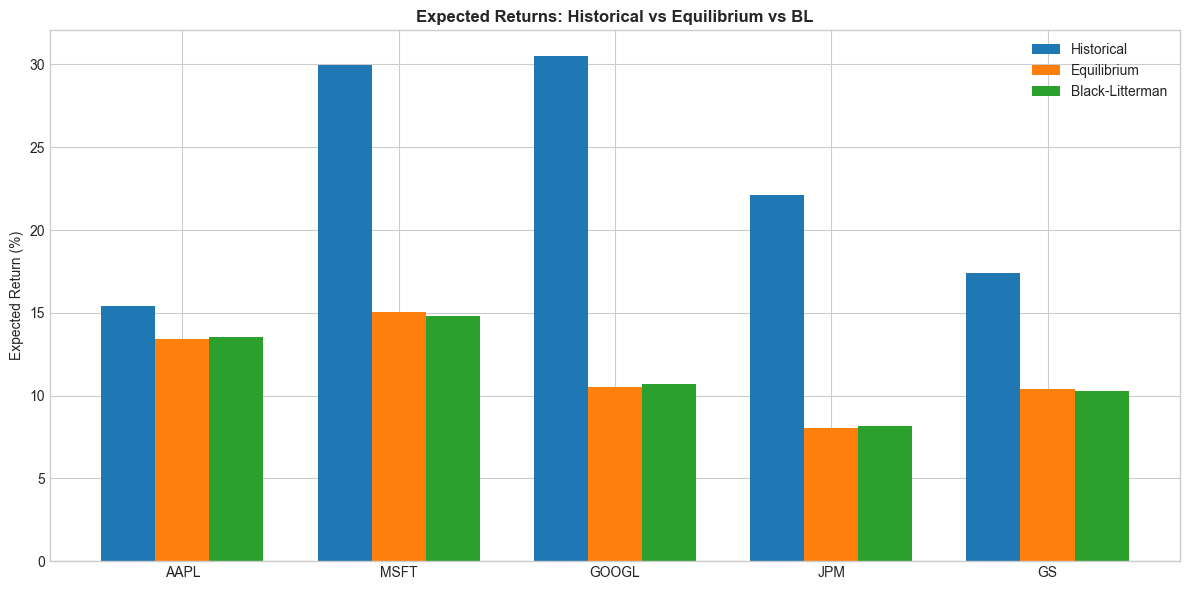

In [5]:
# Visualize return differences
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(tickers))
width = 0.25

ax.bar(x - width, historical_returns.values * 100, width, label='Historical')
ax.bar(x, equilibrium_returns * 100, width, label='Equilibrium')
ax.bar(x + width, bl_returns * 100, width, label='Black-Litterman')

ax.set_xticks(x)
ax.set_xticklabels(tickers)
ax.set_ylabel('Expected Return (%)')
ax.set_title('Expected Returns: Historical vs Equilibrium vs BL', fontweight='bold')
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

## 4. Optimal Portfolios Comparison

In [6]:
# Compare optimal portfolios
print("=" * 60)
print("OPTIMAL PORTFOLIO COMPARISON")
print("=" * 60)

def max_sharpe_portfolio(expected_returns, cov_matrix, rf_rate=RF_RATE):
    """Find max Sharpe portfolio."""
    n = len(expected_returns)
    
    def neg_sharpe(w):
        ret = np.dot(w, expected_returns)
        vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        return -(ret - rf_rate) / vol
    
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(n))
    
    result = minimize(neg_sharpe, np.array([1/n]*n), method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

# Different return estimates
portfolios = {}

# Historical returns
portfolios['Historical'] = max_sharpe_portfolio(historical_returns.values, cov_matrix.values)

# Equilibrium returns
portfolios['Equilibrium'] = max_sharpe_portfolio(equilibrium_returns, cov_matrix.values)

# Black-Litterman returns
portfolios['Black-Litterman'] = max_sharpe_portfolio(bl_returns, cov_matrix.values)

# Market weights
portfolios['Market'] = market_weights

# Compare weights
weights_df = pd.DataFrame(portfolios, index=tickers)
print("\n📊 Optimal Weights:")
print(weights_df.round(4))

# Compare performance
print("\n📊 Portfolio Metrics:")
for name, weights in portfolios.items():
    ret = np.dot(weights, bl_returns)  # Use BL returns for fair comparison
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))
    sharpe = (ret - RF_RATE) / vol
    print(f"  {name}: Return={ret:.2%}, Vol={vol:.2%}, Sharpe={sharpe:.3f}")

OPTIMAL PORTFOLIO COMPARISON

📊 Optimal Weights:
       Historical  Equilibrium  Black-Litterman  Market
AAPL       0.0000       0.3957           0.4139  0.3636
MSFT       0.3853       0.4628           0.4228  0.3394
GOOGL      0.6147       0.1415           0.1633  0.2182
JPM        0.0000       0.0000           0.0000  0.0606
GS         0.0000       0.0000           0.0000  0.0182

📊 Portfolio Metrics:
  Historical: Return=12.29%, Vol=24.03%, Sharpe=0.303
  Equilibrium: Return=13.73%, Vol=24.49%, Sharpe=0.357
  Black-Litterman: Return=13.62%, Vol=24.15%, Sharpe=0.357
  Market: Return=12.97%, Vol=22.77%, Sharpe=0.350


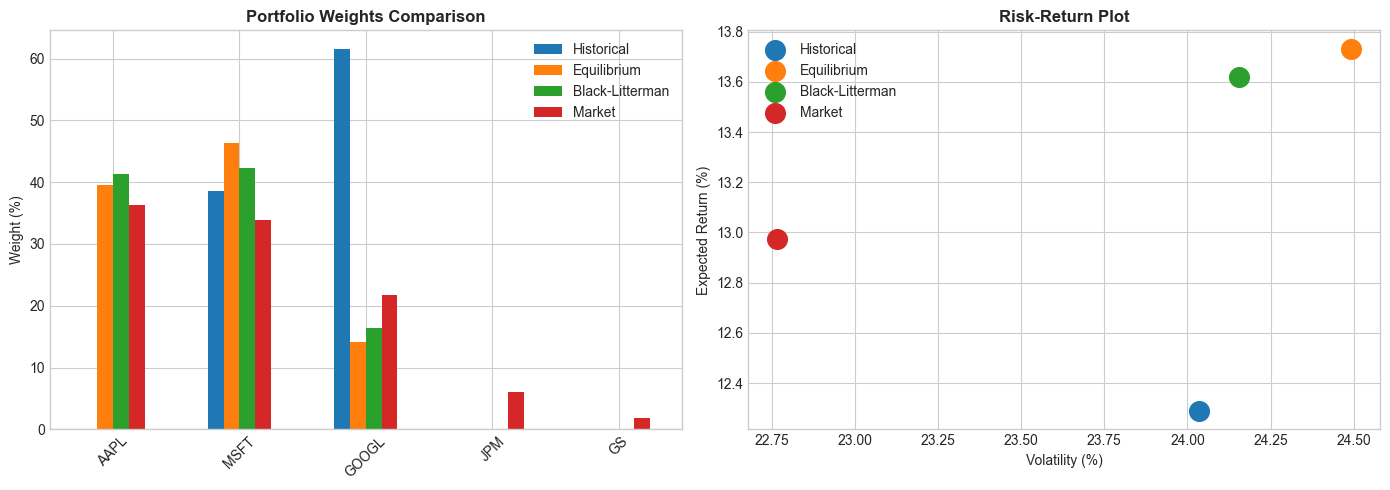

In [7]:
# Visualize portfolios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weight comparison
weights_df_plot = weights_df * 100
weights_df_plot.plot(kind='bar', ax=axes[0])
axes[0].set_ylabel('Weight (%)')
axes[0].set_title('Portfolio Weights Comparison', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc='upper right')

# Risk-return scatter
for name, weights in portfolios.items():
    ret = np.dot(weights, bl_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))
    axes[1].scatter(vol * 100, ret * 100, s=200, label=name)

axes[1].set_xlabel('Volatility (%)')
axes[1].set_ylabel('Expected Return (%)')
axes[1].set_title('Risk-Return Plot', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Sensitivity Analysis

SENSITIVITY ANALYSIS

📊 Impact of View 1 Confidence:
 Confidence  AAPL Weight  MSFT Weight  AAPL Return  MSFT Return
        0.1       0.4016       0.4353       0.1349       0.1492
        0.3       0.4061       0.4308       0.1351       0.1488
        0.5       0.4139       0.4228       0.1354       0.1483
        0.7       0.4311       0.4054       0.1361       0.1471
        0.9       0.4996       0.3374       0.1388       0.1424


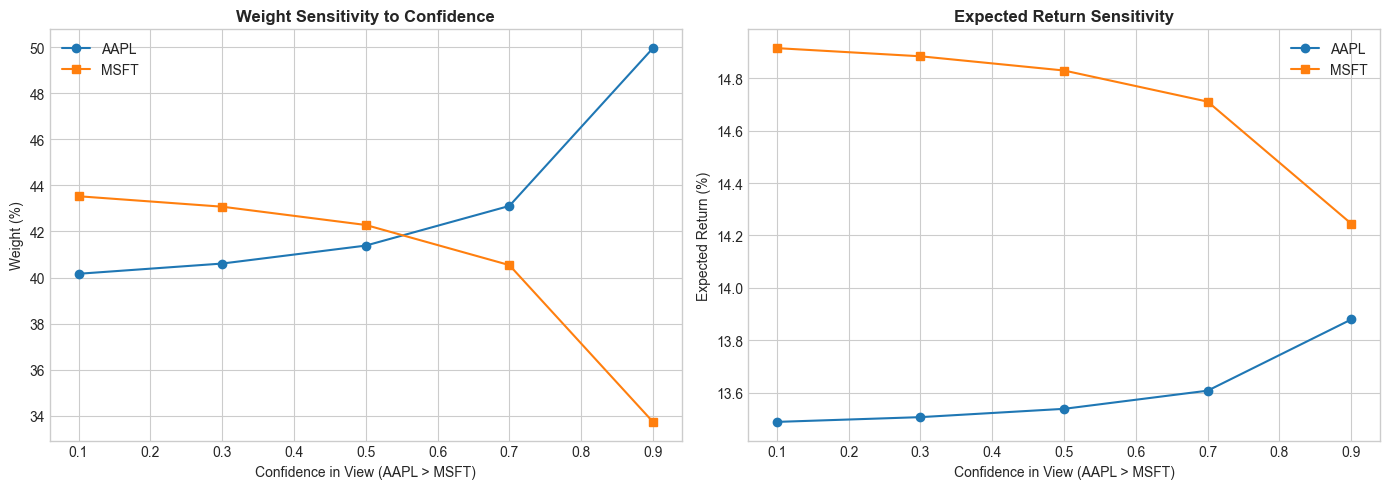

In [8]:
# Sensitivity to view confidence
print("=" * 60)
print("SENSITIVITY ANALYSIS")
print("=" * 60)

# Vary confidence in View 1 (AAPL > MSFT)
confidence_levels = np.linspace(0.1, 0.9, 5)

sensitivity_results = []
for conf in confidence_levels:
    test_confidence = view_confidence.copy()
    test_confidence[0] = conf
    
    bl_ret, _ = black_litterman(
        equilibrium_returns.values, 
        cov_matrix.values, 
        P, Q, 
        test_confidence
    )
    
    optimal_w = max_sharpe_portfolio(bl_ret, cov_matrix.values)
    
    sensitivity_results.append({
        'Confidence': conf,
        'AAPL Weight': optimal_w[0],
        'MSFT Weight': optimal_w[1],
        'AAPL Return': bl_ret[0],
        'MSFT Return': bl_ret[1]
    })

sens_df = pd.DataFrame(sensitivity_results)
print("\n📊 Impact of View 1 Confidence:")
print(sens_df.round(4).to_string(index=False))

# Plot sensitivity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(sens_df['Confidence'], sens_df['AAPL Weight'] * 100, 'o-', label='AAPL')
axes[0].plot(sens_df['Confidence'], sens_df['MSFT Weight'] * 100, 's-', label='MSFT')
axes[0].set_xlabel('Confidence in View (AAPL > MSFT)')
axes[0].set_ylabel('Weight (%)')
axes[0].set_title('Weight Sensitivity to Confidence', fontweight='bold')
axes[0].legend()

axes[1].plot(sens_df['Confidence'], sens_df['AAPL Return'] * 100, 'o-', label='AAPL')
axes[1].plot(sens_df['Confidence'], sens_df['MSFT Return'] * 100, 's-', label='MSFT')
axes[1].set_xlabel('Confidence in View (AAPL > MSFT)')
axes[1].set_ylabel('Expected Return (%)')
axes[1].set_title('Expected Return Sensitivity', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 📝 Key Takeaways - Day 4

### Black-Litterman Advantages:
1. **Intuitive starting point**: Market equilibrium (not historical returns)
2. **Flexible views**: Express views with confidence levels
3. **More stable**: Less extreme weights than traditional MVO
4. **Combines information**: Market wisdom + your views

### Key Formula:
$$\mu_{BL} = [(\tau\Sigma)^{-1} + P'\Omega^{-1}P]^{-1}[(\tau\Sigma)^{-1}\pi + P'\Omega^{-1}Q]$$

Where:
- $\pi$: Equilibrium returns
- $P$: View matrix
- $Q$: View returns
- $\Omega$: View uncertainty
- $\tau$: Equilibrium uncertainty

### Interview Questions:
- "What problem does Black-Litterman solve?"
- "How are equilibrium returns calculated?"
- "How do you incorporate views into BL?"
- "What is tau in the BL model?"

## 🔴 PROS & CONS: Black Litterman

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [9]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Black Litterman Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 15:09

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
